<a href="https://colab.research.google.com/github/koya-namba/PyTorch_practice/blob/main/LSTM%E3%81%AE%E5%AE%9F%E8%A3%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM
次の状態$(t_i)$を計算する際に，前の状態$(t_{i-1})$も考慮する．

一連の情報をシーケンスという．

シーケンスを元にして，少しだけ先の情報を含めたシーケンスを返す．

RNNが基本であり，隠れ層に時刻のトレンドを持たせて再帰的に更新する．

RNNを発展させた，LSTMを用いることが多い．

実際に使う際には，線形層とセットで使う．

lstmの出力は，出力値と隠れ層とセルの状態を返す．

また，出力値はシーケンス，バッチ，隠れ層のサイズを持っている．

予測に使うのは，ラストのみ．

## 今回の実装について
時系列データには，簡単のためsin波を用いる．
(データの数が少なく，周期性がないときはうまく学習できないため．)

データの数がそんなに多くないため，バッチ学習とする．

## ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
%matplotlib inline

## データの作成

シークエンスの作成も行う

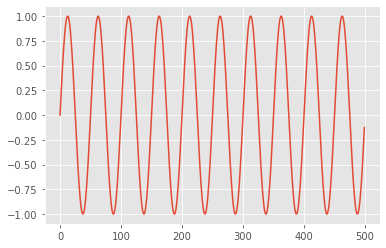

In [3]:
x = np.linspace(0, 499, 500)
y = np.sin(x * 2 * np.pi / 50)
plt.plot(x, y)

今回は490を学習用と用いて，10をテスト用とする．



In [4]:
def make_sequence_data(y, num_sequence):
    num_data = len(y)
    seq_data = []
    target_data = []
    for i in range(num_data - num_sequence):
        seq_data.append(y[i : i+num_sequence])
        target_data.append(y[i+num_sequence : i+num_sequence+1])
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)
    return seq_arr, target_arr

seq_lengthはデータを見て決めるのが理想．

短いほど予測するのが，困難になる．

In [5]:
seq_length=40
y_seq, y_target = make_sequence_data(y, seq_length)

In [6]:
y_seq.shape

(460, 40)

In [7]:
y_target.shape

(460, 1)

学習データとテストデータに分割

In [9]:
num_test = 10
y_seq_train = y_seq[: -num_test]
y_seq_test = y_seq[-num_test :]
y_target_train = y_target[: -num_test]
y_target_test = y_target[-num_test :]

In [10]:
print(y_seq_train.shape)
print(y_seq_test.shape)
print(y_target_train.shape)
print(y_target_test.shape)

(450, 40)
(10, 40)
(450, 1)
(10, 1)


Tensorに変換

In [11]:
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)

In [16]:
class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x_last = x[-1]
        x = self.linear(x_last)
        return x

In [17]:
model = LSTM(100)

In [19]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
y_seq_t.size()

torch.Size([450, 40])

順番について，シークエンスが先で，バッチサイズになる．

In [21]:
y_seq_t = y_seq_t.permute(1, 0)
y_target_t = y_target_t.permute(1, 0)

In [22]:
y_seq_t.size()

torch.Size([40, 450])

３次元にする必要がある．

In [23]:
y_seq_t = y_seq_t.unsqueeze(dim=-1)
y_target_t = y_target_t.unsqueeze(dim=-1)

In [24]:
y_seq_t.size()

torch.Size([40, 450, 1])

## 学習

In [25]:
num_epochs = 80
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(y_seq_t)
    loss = criterion(output, y_target_t)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 10 == 0:
        print('epoch: {}, loss: {}'.format(epoch, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 450, 1])) that is different to the input size (torch.Size([450, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.5245885848999023
epoch: 10, loss: 0.3992757499217987
epoch: 20, loss: 0.24742776155471802
epoch: 30, loss: 0.08198708295822144
epoch: 40, loss: 0.009230175986886024
epoch: 50, loss: 0.005610746331512928
epoch: 60, loss: 0.0013201185502111912
epoch: 70, loss: 0.0007913588196970522


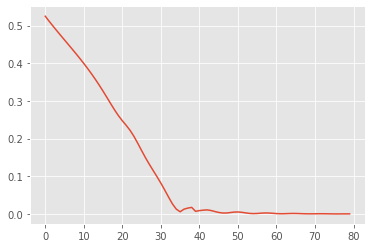

In [26]:
plt.plot(losses)

In [29]:
y_seq_test_t = torch.FloatTensor(y_seq_test)
y_seq_test_t = y_seq_test_t.permute(1, 0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)

In [31]:
y_seq_test_t.size()

torch.Size([40, 10, 1])

In [32]:
y_pred = model(y_seq_test_t)

In [33]:
y_pred.size()

torch.Size([10, 1])

(450.0, 500.0)

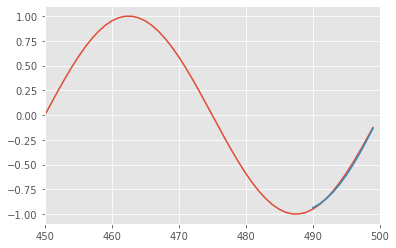

In [35]:
plt.plot(x, y)
plt.plot(np.arange(490, 500), y_pred.detach())
plt.xlim([450, 500])